In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
train_dir = '/kaggle/input/private-datasetrar/224x224/train'
valid_dir = '/kaggle/input/private-datasetrar/224x224/valid'
test_dir = '/kaggle/input/private-datasetrar/224x224/test'

In [3]:
batch_size = 32
img_height, img_width = (224, 224)
input_shape = (224, 224, 3)
num_classes = 2
EPOCHS = 50

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


Found 1593 images belonging to 2 classes.


In [6]:
valid_generator = train_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 457 images belonging to 2 classes.


In [10]:
test_generator = train_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)


Found 455 images belonging to 2 classes.


In [34]:
x, y = test_generator.next()
x.shape  # Display to confirm the shape of the input

(1, 224, 224, 3)

In [35]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Diseased', 'Healthy']


In [36]:
target_names = ['Diseased', 'Healthy']

In [24]:
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=train_generator.image_shape)
x = base_model.output
x = Flatten()(x)
x = Dropout(0.7)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions, name='MobileNetV3Large')

for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "MobileNetV3Large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                   

In [27]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Custom callback to save the model at specific epochs
class SaveModelAtEpochs(Callback):
    def __init__(self, checkpoint_filepath, save_epochs):
        super(SaveModelAtEpochs, self).__init__()
        self.checkpoint_filepath = checkpoint_filepath
        self.save_epochs = save_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:
            self.model.save(self.checkpoint_filepath.format(epoch=epoch+1))

# Define the checkpoint filepath for the best model
checkpoint_filepath_best = '/kaggle/working/MobilenetV3/50epoch.{epoch:02d}-{val_loss:.2f}.h5'

# Create the ModelCheckpoint callback for the best model
checkpoint_best = ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define the checkpoint filepath and save epochs for the custom callback
checkpoint_filepath_epochs = '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_{epoch}.h5'
save_epochs = [10, 20, 30, 40, 50]

# Create the custom callback to save the model at specific epochs
custom_checkpoint = SaveModelAtEpochs(checkpoint_filepath_epochs, save_epochs)



In [28]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[checkpoint_best, custom_checkpoint]
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.7979
Epoch 1: val_accuracy improved from -inf to 0.92560, saving model to /kaggle/working/MobilenetV3/50epoch.01-0.19.h5
50/50 [==============================] - 43s 644ms/step - loss: 0.6818 - accuracy: 0.7979 - val_loss: 0.1868 - val_accuracy: 0.9256
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8970
Epoch 2: val_accuracy improved from 0.92560 to 0.94530, saving model to /kaggle/working/MobilenetV3/50epoch.02-0.14.h5
50/50 [==============================] - 28s 563ms/step - loss: 0.3266 - accuracy: 0.8970 - val_loss: 0.1410 - val_accuracy: 0.9453
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.9184
Epoch 3: val_accuracy did not improve from 0.94530
50/50 [==============================] - 25s 495ms/step - loss: 0.2701 - accuracy: 0.9184 - val_loss: 0.1989 - val_accuracy: 0.9300
Epoch 4/50
50/50 [==================

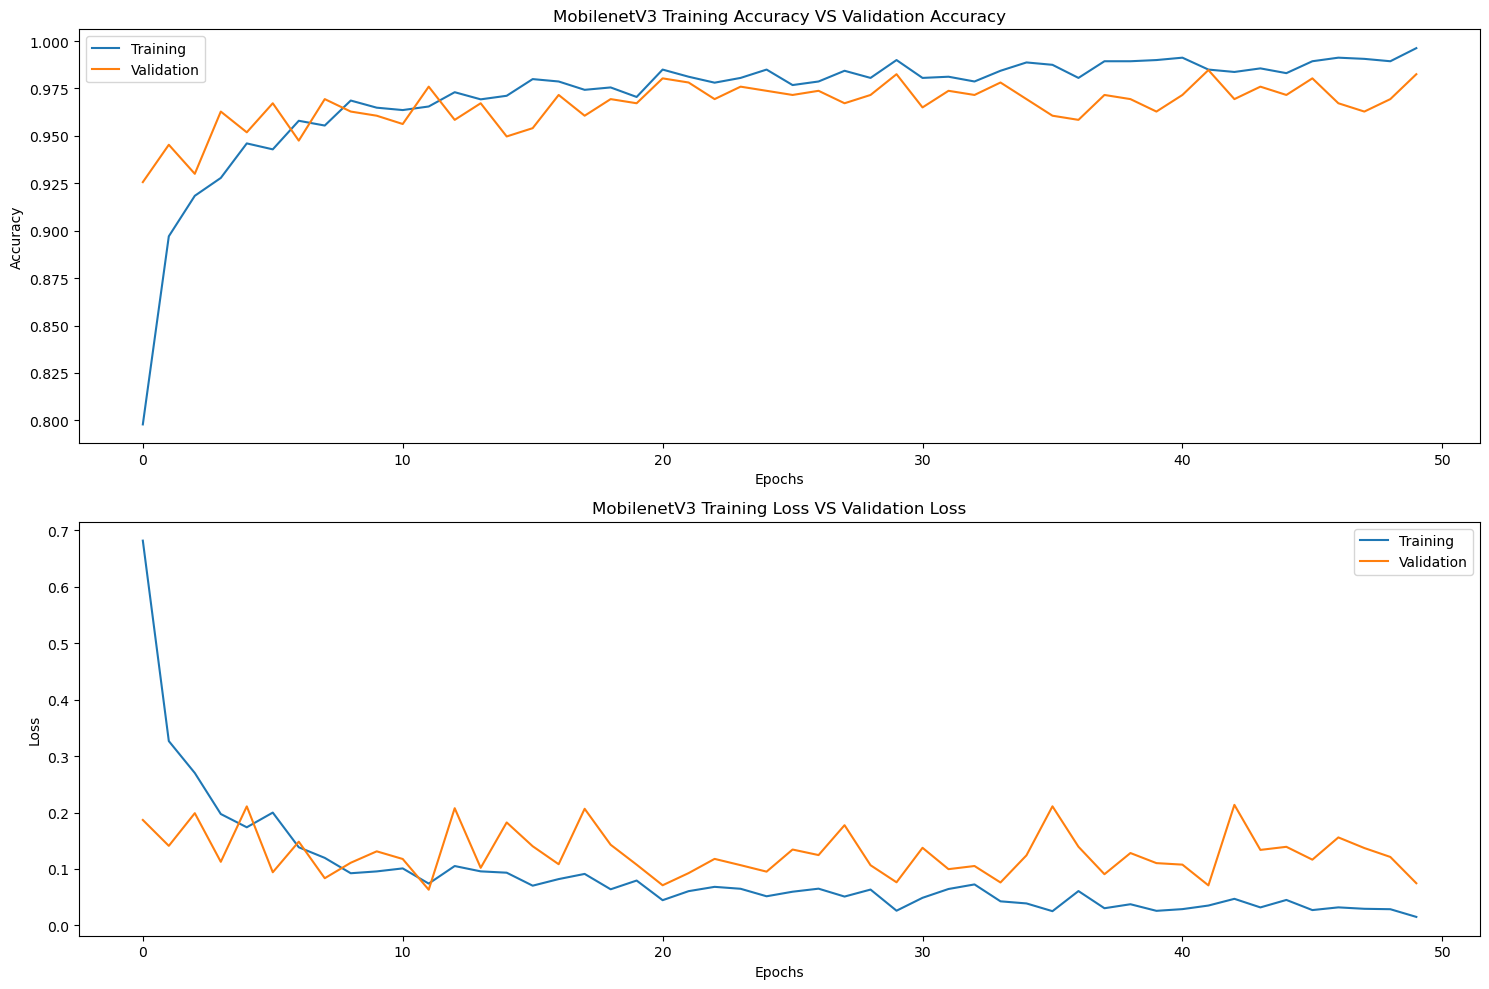

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot Training Accuracy and Validation Accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('MobilenetV3 Training Accuracy VS Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Training', 'Validation'])

# Plot Training Loss and Validation Loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('MobilenetV3 Training Loss VS Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()

In [31]:
import glob
import os
# Loading the best model
saved_models_dir = '/kaggle/working/MobilenetV3/'
saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
saved_model_files.sort()
best_model_file = saved_model_files[-1]
best_model = tf.keras.models.load_model(best_model_file)

# Saving the best model with a different name
best_model.save('/kaggle/working/MobilenetV3/Saved_Model/Best_MobilenetV3.h5')


In [32]:
# Evaluating the best model on the validation set
test_loss, test_acc = best_model.evaluate(valid_generator, verbose=2)
print('\nVal_accuracy: ', test_acc)
print('\nVal_loss: ', test_loss)


457/457 - 8s - loss: 0.0746 - accuracy: 0.9781 - 8s/epoch - 17ms/step

Val_accuracy:  0.9781181812286377

Val_loss:  0.07461540400981903


For the best MobileNetV3 model:
1/1 [==============================] - 0s 23ms/step
Test accuracy: 96.26373626373626


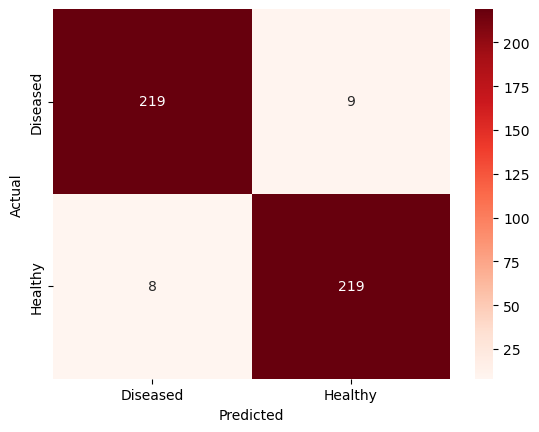

              precision    recall  f1-score   support

    Diseased       0.96      0.96      0.96       228
     Healthy       0.96      0.96      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



In [37]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report for the best model
print("For the best MobileNetV3 model:")
filenames = test_generator.filenames
nb_samples = len(test_generator)

y_prob = []
y_act = []

test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(best_model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))
# Generate classification report
plt.show()
classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)

print(classification_rep)


Epoch 1
1/1 [==============================] - 0s 23ms/step


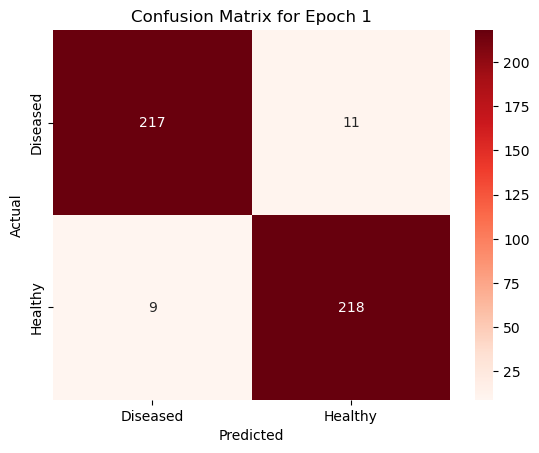

Test accuracy: 95.6043956043956
              precision    recall  f1-score   support

    Diseased       0.96      0.95      0.96       228
     Healthy       0.95      0.96      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 2
1/1 [==============================] - 0s 27ms/step


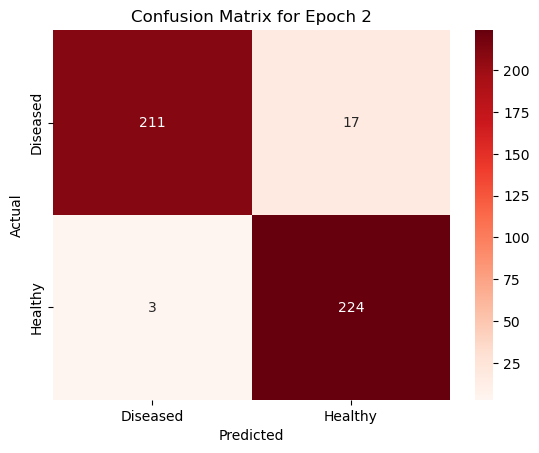

Test accuracy: 95.6043956043956
              precision    recall  f1-score   support

    Diseased       0.99      0.93      0.95       228
     Healthy       0.93      0.99      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 3
1/1 [==============================] - 0s 23ms/step


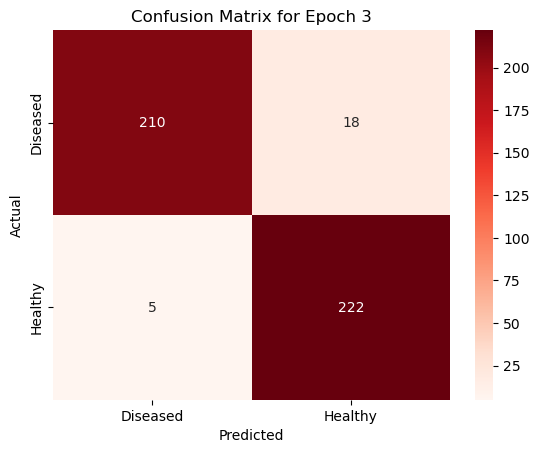

Test accuracy: 94.94505494505493
              precision    recall  f1-score   support

    Diseased       0.98      0.92      0.95       228
     Healthy       0.93      0.98      0.95       227

    accuracy                           0.95       455
   macro avg       0.95      0.95      0.95       455
weighted avg       0.95      0.95      0.95       455

-----------------------------------------------------
Epoch 4
1/1 [==============================] - 0s 28ms/step


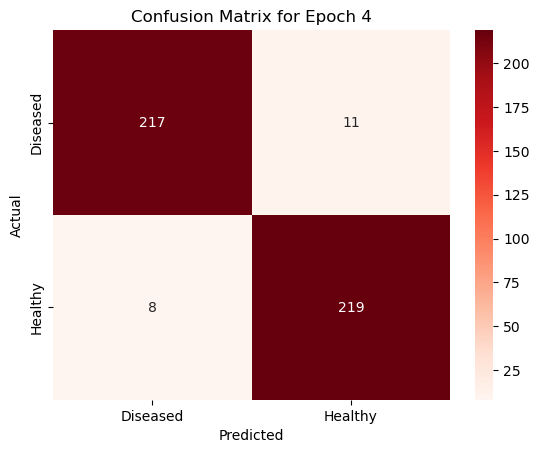

Test accuracy: 95.82417582417582
              precision    recall  f1-score   support

    Diseased       0.96      0.95      0.96       228
     Healthy       0.95      0.96      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 5
1/1 [==============================] - 0s 22ms/step


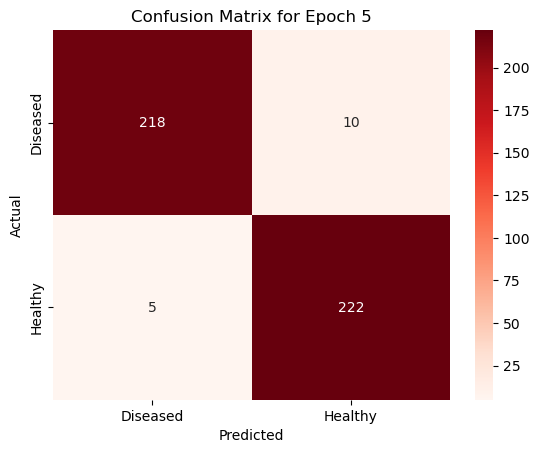

Test accuracy: 96.7032967032967
              precision    recall  f1-score   support

    Diseased       0.98      0.96      0.97       228
     Healthy       0.96      0.98      0.97       227

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455

-----------------------------------------------------


In [38]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

saved_model_filepaths = [
    '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_10.h5',
    '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_20.h5',
    '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_30.h5',
    '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_40.h5',
    '/kaggle/working/MobilenetV3/save_by_epochs/MobilenetV3_model_50.h5'
]

# Iterate over the saved model file paths
for epoch, model_filepath in enumerate(saved_model_filepaths, start=1):
    print("Epoch {}".format(epoch))
    
    # Load the model
    model = tf.keras.models.load_model(model_filepath)

    filenames = test_generator.filenames
    nb_samples = len(test_generator)

    y_prob = []
    y_act = []

    test_generator.reset()
    for _ in range(nb_samples):
        X_test, Y_test = test_generator.next()
        y_prob.append(model.predict(X_test))
        y_act.append(Y_test)

    predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
    actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

    out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

    confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
    plt.title('Confusion Matrix for Epoch {}'.format(epoch))
    plt.show()

    print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))

    # Generate classification report
    classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)
    print(classification_rep)
    print("-----------------------------------------------------")
